In [2]:
import functools
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import scipy
from sklearn.model_selection import train_test_split
import time
import tqdm
from anndata import AnnData
import scanpy as sc

In [3]:
# Spatial LDA imports
from spatial_lda.featurization import featurize_tumors
from spatial_lda.featurization import neighborhood_to_marker
from spatial_lda.featurization import make_merged_difference_matrices
import spatial_lda.model
from spatial_lda.visualization import plot_samples_in_a_row
from spatial_lda.visualization import plot_one_tumor_all_topics
from spatial_lda.visualization import plot_one_tumor_topic
from spatial_lda.visualization import plot_topics_heatmap
from spatial_lda.visualization import plot_adjacency_graph

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Set data path
data_path = "D:/Desktop/MGI/CODE/"

In [4]:
with open(data_path + "Data/patient_dfs.pkl", 'rb') as f:
   patient_dfs = pickle.load(f)
patient_dfs

{1:             Au  Background  Beta catenin        Ca  CD11b     CD11c  CD138  \
 0     3.449781    0.164687           0.0  2.609307    0.0  0.000000    0.0   
 1     3.441198    0.168433           0.0  2.711448    0.0  0.130399    0.0   
 2     1.233291    0.215964           0.0  2.186117    0.0  0.000000    0.0   
 3     2.032927    0.112490           0.0  2.142954    0.0  0.000000    0.0   
 4     1.987532    0.084782           0.0  1.673678    0.0  0.000000    0.0   
 ...        ...         ...           ...       ...    ...       ...    ...   
 5235  0.204912    0.095095           0.0  1.993685    0.0  0.000000    0.0   
 5236  0.734866    0.028165           0.0  1.167104    0.0  0.000000    0.0   
 5237  0.230107    0.035707           0.0  1.112817    0.0  0.000000    0.0   
 5238  1.057317    0.046858           0.0  1.575251    0.0  0.000000    0.0   
 5239  0.755760    0.063787           0.0  1.534930    0.0  0.000000    0.0   
 
       CD16      CD20  CD209  ...        Si    

In [6]:
for patient_id in patient_dfs.keys():
  df = patient_dfs[patient_id]
  df['combined_cluster_id'] = (df['immune_cluster'].fillna(0) + 
                               (df.cluster_id + 12).fillna(0))
  df.loc[df['combined_cluster_id'] == 0, 'combined_cluster_id'] = None
  df.loc[:, 'is_tumor'] = ~df['isimmune']
  patient_dfs[patient_id] = df

type(patient_dfs)

dict

In [7]:
with open(data_path + "Data/tumor_marker_features.pkl", 'rb') as f:
    tumor_marker_features = pickle.load(f)
tumor_marker_features

,Beta catenin,Ca,CD11b,CD11c,CD138,CD16,CD20,CD209,CD3,CD31,...,P,p53,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin
"(1, 0)",0,11,0,0,0,0,2,0,0,0,...,10,0,0,0,0,7,7,1,9,2
"(1, 2)",0,12,0,0,0,0,1,0,0,0,...,10,0,0,0,0,5,4,2,7,3
"(1, 4)",0,14,0,0,0,0,3,0,0,0,...,13,0,0,0,0,7,3,2,7,3
"(1, 5)",0,12,0,0,0,0,3,0,0,0,...,11,0,0,0,0,5,2,2,6,3
"(1, 6)",0,11,0,0,0,0,4,0,0,0,...,10,0,0,0,0,5,0,2,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(41, 4559)",0,10,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,8,0,4,5
"(41, 4560)",0,5,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,5,0,4,2
"(41, 4561)",0,10,0,0,0,0,0,0,0,0,...,9,0,0,0,0,0,9,0,6,7
"(41, 4563)",0,4,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,4,0,4,3


In [8]:
tumor_marker_features.loc[[index for index in tumor_marker_features.index if index[0] == 41]]

,Beta catenin,Ca,CD11b,CD11c,CD138,CD16,CD20,CD209,CD3,CD31,...,P,p53,Pan-Keratin,PD-L1,PD1,phospho-S6,Si,SMA,Ta,Vimentin
"(41, 16)",0,2,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,2,0,2,2
"(41, 17)",0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
"(41, 18)",0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
"(41, 19)",0,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,1
"(41, 20)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(41, 4559)",0,10,0,0,0,0,0,0,0,0,...,10,0,0,0,0,0,8,0,4,5
"(41, 4560)",0,5,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,5,0,4,2
"(41, 4561)",0,10,0,0,0,0,0,0,0,0,...,9,0,0,0,0,0,9,0,6,7
"(41, 4563)",0,4,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,4,0,4,3


In [5]:
data = sc.read_h5ad(data_path + "Data/SS200000116BR_E6.bin200.h5ad")

# annotation data
anno_data = pd.read_csv(data_path + "Output/RCTD_results.csv", index_col=0)
anno_data.index = anno_data.index.rename('ID')
anno_data.reset_index(inplace=True)
anno_data.drop(['x', 'y'], axis=1, inplace=True)
anno_data

,ID,spot_class,first_type,second_type,first_prob,second_prob,final_type
0,27487790701800,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang
1,29205777624400,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang
2,31782757998200,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang
3,32641751459800,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang
4,39513699138800,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang
...,...,...,...,...,...,...,...
10184,6012954233600,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte
10185,2576980383000,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte
10186,17179869208000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang
10187,11166914969600,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang


In [6]:
data_obs = data.obs.copy()
data_obs.index = data_obs.index.rename('ID')
data_obs.reset_index(inplace=True)

data_obs['ID'] = data_obs['ID'].astype(str)
anno_data['ID'] = anno_data['ID'].astype(str)

merged_data = pd.merge(data_obs, anno_data, on='ID', how='inner')
merged_data

,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang
...,...,...,...,...,...,...,...,...,...,...
10184,6012954233600,sample,1400,19200,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte
10185,2576980383000,sample,600,5400,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte
10186,17179869208000,sample,4000,24000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang
10187,11166914969600,sample,2600,0,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang


In [7]:
merged_data['is_tumor'] = np.where(merged_data['final_type'] == 'Tumor-Cholang', True, False)
merged_data

,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type,is_tumor
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang,True
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang,True
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang,True
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang,True
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang,True
...,...,...,...,...,...,...,...,...,...,...,...
10184,6012954233600,sample,1400,19200,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte,False
10185,2576980383000,sample,600,5400,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte,False
10186,17179869208000,sample,4000,24000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang,True
10187,11166914969600,sample,2600,0,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang,True


In [8]:
# Dataframe to Anndata
merged_data_ann = AnnData(obs=merged_data, var=data.var)
merged_data_ann.obs

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,ID,orig.ident,x,y,spot_class,first_type,second_type,first_prob,second_prob,final_type,is_tumor
0,27487790701800,sample,6400,7400,doublet_certain,Hepatocyte,Tumor-Cholang,0.363940,0.636060,Tumor-Cholang,True
1,29205777624400,sample,6800,11600,doublet_certain,Tumor-Cholang,Hepatocyte,0.635929,0.364071,Tumor-Cholang,True
2,31782757998200,sample,7400,7800,doublet_certain,Tumor-Cholang,Hepatocyte,0.638376,0.361624,Tumor-Cholang,True
3,32641751459800,sample,7600,10200,doublet_certain,Tumor-Cholang,Hepatocyte,0.723940,0.276060,Tumor-Cholang,True
4,39513699138800,sample,9200,15600,doublet_certain,Tumor-Cholang,Hepatocyte,0.862991,0.137009,Tumor-Cholang,True
...,...,...,...,...,...,...,...,...,...,...,...
10184,6012954233600,sample,1400,19200,singlet,Hepatocyte,Endothelial,0.544437,0.455563,Hepatocyte,False
10185,2576980383000,sample,600,5400,singlet,Hepatocyte,Tumor-Cholang,0.536803,0.463197,Hepatocyte,False
10186,17179869208000,sample,4000,24000,singlet,Hepatocyte,Tumor-Cholang,0.397441,0.602559,Tumor-Cholang,True
10187,11166914969600,sample,2600,0,doublet_certain,Hepatocyte,Tumor-Cholang,0.370117,0.629883,Tumor-Cholang,True


In [9]:
aligned_X = data[data.obs.index.isin(merged_data_ann.obs["ID"])].X
print(aligned_X.toarray())

[[  3.   0.   0. ...   5.   5.  66.]
 [  2.   0.   0. ...   4.  12. 110.]
 [  1.   0.   0. ...  24.  14. 167.]
 ...
 [  0.   0.   0. ...   0.   0.  13.]
 [  0.   0.   0. ...   0.   0.   1.]
 [  0.   0.   0. ...   0.   0.   1.]]


In [10]:
merged_data_ann = AnnData(X=aligned_X.toarray(), obs=merged_data, var=data.var)
merged_data_ann

c:\Users\40868\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 10189 × 30523
    obs: 'ID', 'orig.ident', 'x', 'y', 'spot_class', 'first_type', 'second_type', 'first_prob', 'second_prob', 'final_type', 'is_tumor'

In [11]:
features = pd.DataFrame(merged_data_ann.X.astype(int), columns=merged_data_ann.var.index)
features.index = [(1, idx) for idx in features.index]
features

,AL354822.1,AC233755.2,AC007325.2,AC011841.1,MAFIP,BX004987.1,AC136616.1,AC136612.1,TTTY3B,DAZ2,...,AEBP1,KLHL8,AC237221.1,AC006455.1,SELENOI,HABP2,SEC61G,HSP90B1,IGFBP1,SERPINA1
"(1, 0)",3,0,0,0,0,0,0,0,0,0,...,3,0,0,0,0,1,2,5,5,66
"(1, 1)",2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,5,4,12,110
"(1, 2)",1,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,6,5,24,14,167
"(1, 3)",1,0,0,0,0,0,0,0,0,0,...,3,0,0,0,1,4,2,10,9,99
"(1, 4)",1,0,0,0,0,0,0,0,0,0,...,17,1,0,0,6,25,56,148,44,781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(1, 10184)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
"(1, 10185)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"(1, 10186)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,13
"(1, 10187)",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [12]:
patient = merged_data_ann.obs
patient.reset_index(drop=True, inplace=True)

patient_dict = dict()

patient_dict[1] = patient
patient_dict

{1:                    ID orig.ident      x      y       spot_class  \
 0      27487790701800     sample   6400   7400  doublet_certain   
 1      29205777624400     sample   6800  11600  doublet_certain   
 2      31782757998200     sample   7400   7800  doublet_certain   
 3      32641751459800     sample   7600  10200  doublet_certain   
 4      39513699138800     sample   9200  15600  doublet_certain   
 ...               ...        ...    ...    ...              ...   
 10184   6012954233600     sample   1400  19200          singlet   
 10185   2576980383000     sample    600   5400          singlet   
 10186  17179869208000     sample   4000  24000          singlet   
 10187  11166914969600     sample   2600      0  doublet_certain   
 10188  60988535603800     sample  14200    600          singlet   
 
           first_type    second_type  first_prob  second_prob     final_type  \
 0         Hepatocyte  Tumor-Cholang    0.363940     0.636060  Tumor-Cholang   
 1      Tumor-Chola

In [13]:
TRAIN_SIZE_FRACTION = 0.9

_sets = train_test_split(features, test_size=1. - TRAIN_SIZE_FRACTION)

train_features, test_features = _sets


In [14]:
train_difference_matrices = make_merged_difference_matrices(train_features, patient_dict, 'x', 'y')

In [ ]:
def make_plot_fn(difference_matrices):  
    def plot_fn(ax, tumor_idx, features_df, patient_dfs):
        plot_adjacency_graph(ax, tumor_idx, features_df, patient_dfs, difference_matrices)
    return plot_fn
_plot_fn = make_plot_fn(train_difference_matrices)

plot_samples_in_a_row(train_features, _plot_fn, patient_dfs, tumor_set=[3, 4, 5, 9, 28])

In [15]:
N_PARALLEL_PROCESSES = 8
TRAIN_SIZE_FRACTION = 0.9 
N_TOPICS = 5 
DIFFERENCE_PENALTY = 250 
RETRAIN_MODEL = True

In [16]:
spatial_lda_model = spatial_lda.model.train(train_features, 
                                            train_difference_matrices, 
                                            n_topics=N_TOPICS, 
                                            difference_penalty=DIFFERENCE_PENALTY, 
                                            verbosity=1,
                                            n_parallel_processes=N_PARALLEL_PROCESSES,
                                            n_iters=3,
                                            admm_rho=0.1,
                                            primal_dual_mu=2)

LDA training: 100%|██████████| 5/5 [01:02<00:00, 12.58s/it]


In [23]:
with open(data_path + "Model/spatial_lda.pkl", 'wb') as f:
    pickle.dump(spatial_lda_model, f)

In [24]:
with open(data_path + "Model/spatial_lda.pkl", 'rb') as f:
    complete_lda = pickle.load(f)

TypeError: 'Axes' object is not subscriptable

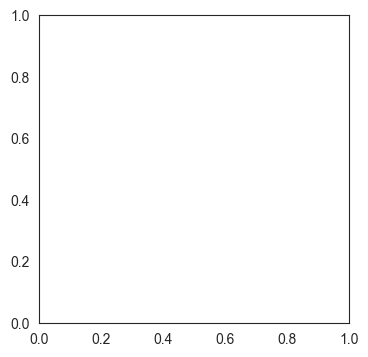

In [26]:
plot_samples_in_a_row(complete_lda.topic_weights, plot_one_tumor_all_topics, patient_dict)

<Axes: >

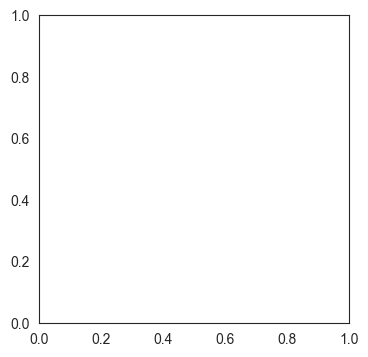

In [38]:
num_rows = 1
num_cols = 1

_, axes = plt.subplots(
        num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))

# if type(axes) != 'numpy.ndarray':
#     axes = np.array([axes])

axes